In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import urllib
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
print(tf.__version__)

2.19.0


In [2]:
#Get CPU info
!cat /proc/cpuinfo
#Get GPU info
#!nividia-smi

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.152
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data re

In [ ]:
#With Google COLAB, it allow to mount my Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Create a 'data/' directory, put the numpy files and load. With Colab case, create 'data' here:
X_imagenette=np.load("/content/drive/MyDrive/Colab Notebooks/data/X_imagenette.npy")
Y_imagenette=np.load("/content/drive/MyDrive/Colab Notebooks/data/Y_imagenette.npy")
print(np.shape(X_imagenette))
print(np.shape(Y_imagenette))
nb_labels=5

(6644, 64, 64, 3)
(6644,)


Text(1, 2, '3')

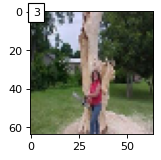

In [ ]:
#Here is an example of an image of the dataset
plt.figure(figsize=(2, 2), dpi=80)
i = np.random.randint(1000)
plt.imshow(X_imagenette[i])
plt.text(1, 2, Y_imagenette[i],bbox=dict(facecolor='white')) #in order to make the label readable on the image


---


A pixel is an UINT8 value, so in [0;255]. We will normalize data in [0,1]:

In [5]:
print("First pixel (r,g,b) of the first image:", X_imagenette[0,0,0,:])
X = X_imagenette/255.0
print("Now in [0,1] ==> ", X[0,0,0,:])


First pixel (r,g,b) of the first image: [254 254 254]
Now in [0,1] ==>  [0.99607843 0.99607843 0.99607843]


For the labels **Y**, usually, we prefer to process "one-hot encodings" i.e., a vector with '0' everywhere except for the corresponding label where you have '1'.

Example : let's say you have 5 labels and 10 training data with the original Y:
```
Y=[0,1,1,3,4,3,2,2,1,0]
shape(Y)=[10,]
```
Then the "one-hot encoding" version of Y will be:

```
Y_onehot=
[1,0,0,0,0;
 0,1,0,0,0;
 0,1,0,0,0;
 0,0,0,1,0;
 0,0,0,0,1;
 0,0,0,1,0;
 0,0,1,0,0;
 0,0,1,0,0;
 0,1,0,0,0;
 1,0,0,0,0]
shape(Y_onehot)=[10,5]
```



In [6]:
Y = tf.keras.utils.to_categorical(Y_imagenette, num_classes = 5)

print("Shape of Y:", Y.shape)


Shape of Y: (6644, 5)


---


# CREATE A TRAINING/VALIDATION/TEST DATASET

I use the SKLEARN method [train_test_split](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) in order to create:

*   a TRAIN set (X_train,Y_train) _[advice: use 70% of the whole dataset]_
*   a VALIDATION set (X_val, Y_val) _[advice: 15%]_
*   a TEST set (X_test, Y_test) _[advice: 15%]_

The TRAIN and VALIDATION sets will be used at training time. The TEST set will be used, after the training, at the inference time.




In [7]:
#CREATE A TRAINING/ VALIDATION/TEST dataset
from sklearn.model_selection import train_test_split

# 1) 1st slice : TRAIN (70%) / DRAFT (30%)
X_train, X_draft, Y_train, Y_draft = train_test_split( X, Y, test_size=0.30,random_state=42) #the 30% part is called "draft" because it is meant to be split again

# 2) 2nd slice : VALIDATION (15%) / TEST (15%)
X_val, X_test, Y_val, Y_test = train_test_split(X_draft, Y_draft,test_size=0.50,random_state=42)

# Print shapes
print("X_train shape:", X_train.shape, "Y_train shape:", Y_train.shape) #we obtain 4650 items after the slices (we can check the result : 4650/6644 = 0.7, that's okay, knowing that 6644 is the total number of items)
print("X_val   shape:", X_val.shape,   "Y_val   shape:", Y_val.shape)
print("X_test  shape:", X_test.shape,  "Y_test  shape:", Y_test.shape)



X_train shape: (4650, 64, 64, 3) Y_train shape: (4650, 5)
X_val   shape: (997, 64, 64, 3) Y_val   shape: (997, 5)
X_test  shape: (997, 64, 64, 3) Y_test  shape: (997, 5)


The train set is used to learn, the validation set is used to check the learning during training, and the test set is used at the end to evaluate the model.

---


# MULTI-LAYER PERCEPTRON (MLP) MODEL 

This code implements a Multilayer Perceptron (MLP) for image classification of 64×64 RGB images into 5 classes using TensorFlow/Keras.
The model first applies data augmentation layers (random horizontal flipping and rotation), then flattens the input image and processes it through two fully connected layers with 32 neurons and ReLU activation.
The output layer uses a softmax activation to produce class probabilities.
The model is trained using the Adam optimizer, categorical cross-entropy loss, and evaluated with accuracy on both training and test datasets.

In [ ]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
import tensorflow as tf

inputs = tf.keras.Input(shape=(64,64,3))             #my input layer
x=tf.keras.layers.RandomFlip("horizontal")(inputs)   #two "data augmentation" layers
x=tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.Flatten()(x)                     #Cf. question below...

x = tf.keras.layers.Dense(32, activation='relu')(x)  #a first hidden layer with 32 neurons
x = tf.keras.layers.Dense(32, activation='relu')(x)  #a second hidden layer with 32 neurons

outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # my output layer

#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
#(a) Set the number of epochs
nb_epochs=5

#(b) Set the size of the (mini)batch
batch_size=150

#(c) Set the training dataset and the validation dataset (X_train, Y_train) and (X_val, Y_val)
#(d) Run the training process with the 'fit' method
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

# (4) COMPUTE THE ACCURACY ON THE TRAINING AND VALIDATION/TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       393,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,469 (1.50 MB)

 Trainable params: 394,469 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2263 - loss: 1.8250 - val_accuracy: 0.3711 - val_loss: 1.4400
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3853 - loss: 1.4317 - val_accuracy: 0.3842 - val_loss: 1.4089
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3956 - loss: 1.4083 - val_accuracy: 0.4193 - val_loss: 1.3734
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4190 - loss: 1.3798 - val_accuracy: 0.4193 - val_loss: 1.3266
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4529 - loss: 1.3367 - val_accuracy: 0.4343 - val_loss: 1.3107
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4595 - loss: 1.2972
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4330 - loss: 1.3668
Performance on the TRAIN set, ACCURACY= 0.4681720435619354
Performance on the TEST set, ACCURACY= 0.43731194734573364


---

We could try with **20 EPOCHS** for example :
  
  

In [ ]:
#Your code here
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
import tensorflow as tf

inputs = tf.keras.Input(shape=(64,64,3))             #my input layer
x=tf.keras.layers.RandomFlip("horizontal")(inputs)   #two "data augmentation" layers
x=tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)  #a first hidden layer with 32 neurons
x = tf.keras.layers.Dense(32, activation='relu')(x)  #a second hidden layer with 32 neurons

outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # my output layer

#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
#(a) Set the number of epochs
nb_epochs=20

#(b) Set the size of the (mini)batch
batch_size=150

#(c) Set the training dataset and the validation dataset (X_train, Y_train) and (X_val, Y_val)
#(d) Run the training process with the 'fit' method
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

# (4) COMPUTE THE ACCURACY ON THE TRAINING AND VALIDATION/TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │       393,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,469 (1.50 MB)

 Trainable params: 394,469 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2357 - loss: 2.2279 - val_accuracy: 0.3159 - val_loss: 1.4770
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3325 - loss: 1.4859 - val_accuracy: 0.3741 - val_loss: 1.4128
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4141 - loss: 1.4131 - val_accuracy: 0.4062 - val_loss: 1.3574
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4315 - loss: 1.3679 - val_accuracy: 0.4142 - val_loss: 1.3303
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4331 - loss: 1.3766 - val_accuracy: 0.4614 - val_loss: 1.2667
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4694 - loss: 1.3171 - val_accuracy: 0.4584 - val_loss: 1.2695
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4822 - loss: 1.2710 - val_accuracy: 0.4684 - val_loss: 1.2670
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4881 - loss: 1.2583 - val_accuracy: 0.4584 - v

It is a bit better with 20 epochs (on the test set, accuracy =0.54 vs 0.44 for 5 epochs and on the train set accuracy = 0.55 vs 0.47 for 5 epochs)

The Flatten layer is needed to convert the image into a 1D vector so it can be used by the Dense layers of the MLP.



394 469 trainable parameters = 64×64×3×32 + 32 (first layer with bias) + 32×32 + 32 (2nd layer with bias) + 32×5 + 5 (output layer + bias)



---


It is always good to have a look on the training curves. That is the role of the "**training_history**" object that is defined in the code as the output of the **fit** method. In this object, we collect all the loss and metric values after each epoch.

You can use the following **method** to display the train/val curves (loss and accuracy):

In [8]:
def display_training_curves(training_history):
  # display loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.plot(training_history.history['val_loss'], label='val_loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()
  #display accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.plot(training_history.history['val_accuracy'], label='val_acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

---

Let's display the training curves from the MLP model.



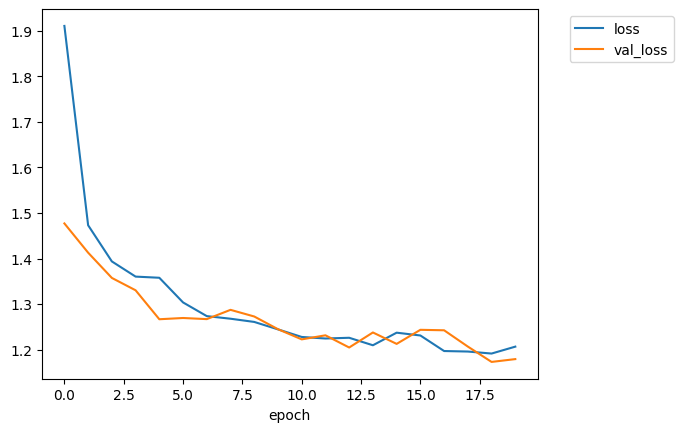

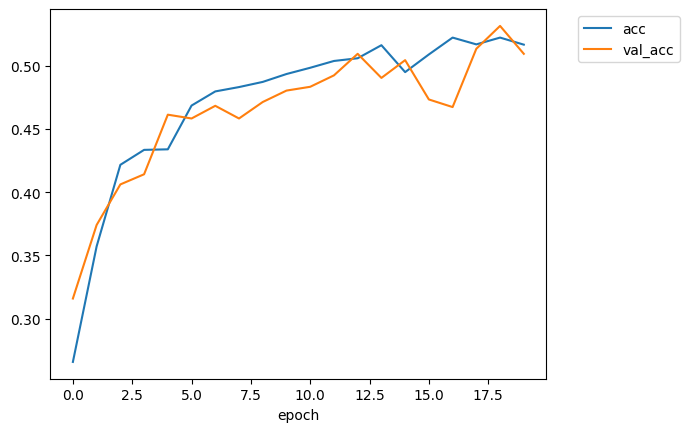

In [ ]:
display_training_curves(training_history)


---


## Improvements and overfitting 

For illustration/educational purpose, I use the previous code of your last model and adapt it so that my model clearly **OVERFITS** on **20 EPOCHS**. 

In [ ]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
import tensorflow as tf

inputs = tf.keras.Input(shape=(64,64,3))             #my input layer
#x=tf.keras.layers.RandomFlip("horizontal")(inputs)   #two "data augmentation" layers, we comment them to remove its effect and foster overfitting
#x=tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(32, activation='relu')(x)  #a first hidden layer with 32 neurons
x = tf.keras.layers.Dense(32, activation='relu')(x)  #a second hidden layer with 32 neurons

outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # my output layer

#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
#(a) Set the number of epochs
nb_epochs=20

#(b) Set the size of the (mini)batch
batch_size=150

#(c) Set the training dataset and the validation dataset (X_train, Y_train) and (X_val, Y_val)
#(d) Run the training process with the 'fit' method
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

# (4) COMPUTE THE ACCURACY ON THE TRAINING AND VALIDATION/TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)



Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │       393,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,469 (1.50 MB)

 Trainable params: 394,469 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.2327 - loss: 1.8031 - val_accuracy: 0.4403 - val_loss: 1.3422
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4397 - loss: 1.3546 - val_accuracy: 0.4303 - val_loss: 1.3234
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4913 - loss: 1.2603 - val_accuracy: 0.4534 - val_loss: 1.3205
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5168 - loss: 1.2095 - val_accuracy: 0.4895 - val_loss: 1.2212
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5389 - loss: 1.1742 - val_accuracy: 0.4905 - val_loss: 1.2195
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5505 - loss: 1.1380 - val_accuracy: 0.4855 - val_loss: 1.2109
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5739 - loss: 1.1158 - val_accuracy: 0.5085 - val_loss: 1.1853
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5897 - loss: 1.0459 - val_accuracy: 0.4855 - val_loss

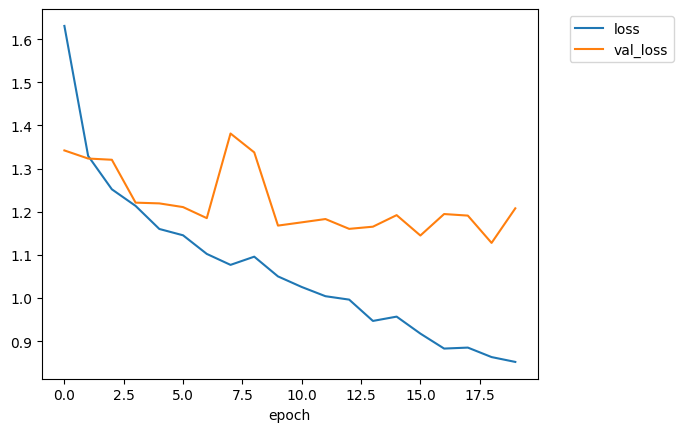

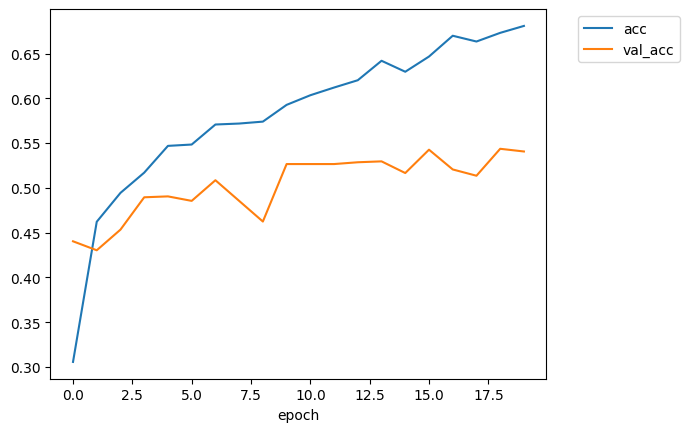

In [ ]:
#Let's check out the curves once we removed data augmentation
display_training_curves(training_history)
#we can see now an increasing gap between the validation loss and the loss as expected for an overfitting case
#accuracy for training goes up to 70% while it stagnates around 50% for validation which is a sign of overfitting ! It shows that the model struggles to generalize.

---

 Now let's fix an overfitting issue with with these constraints:
- Training on **20** epochs
- NO data augmentation
- The first hidden layer must have **512** neurons


In [ ]:

# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
import tensorflow as tf

inputs = tf.keras.Input(shape=(64,64,3))             #my input layer
x = tf.keras.layers.Flatten()(inputs)

x = tf.keras.layers.Dense(512, activation='relu')(x)  #a first hidden layer with 512 neurons
x = tf.keras.layers.Dropout(0.5)(x) #well known technique to fight overfitting, "disabling" some neurons with a probability of 0.5 at each batch
x = tf.keras.layers.Dense(64, activation='relu')(x)  #a second hidden layer with 32 neurons

outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # my output layer

#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
#(a) Set the number of epochs
nb_epochs=20

#(b) Set the size of the (mini)batch
batch_size=150

#(c) Set the training dataset and the validation dataset (X_train, Y_train) and (X_val, Y_val)
#(d) Run the training process with the 'fit' method
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

# (4) COMPUTE THE ACCURACY ON THE TRAINING AND VALIDATION/TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)




Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,325,125 (24.13 MB)

 Trainable params: 6,325,125 (24.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.2260 - loss: 4.9048 - val_accuracy: 0.1946 - val_loss: 1.6085
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2516 - loss: 1.6923 - val_accuracy: 0.3360 - val_loss: 1.5304
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3122 - loss: 1.5567 - val_accuracy: 0.4273 - val_loss: 1.4422
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3949 - loss: 1.4268 - val_accuracy: 0.4493 - val_loss: 1.3664
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4157 - loss: 1.3770 - val_accuracy: 0.4383 - val_loss: 1.2998
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4410 - loss: 1.3336 - val_accuracy: 0.4594 - val_loss: 1.3010
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4544 - loss: 1.3182 - val_accuracy: 0.4574 - val_loss: 1.2765
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4401 - loss: 1.3284 - val_accuracy: 0.4925 - v

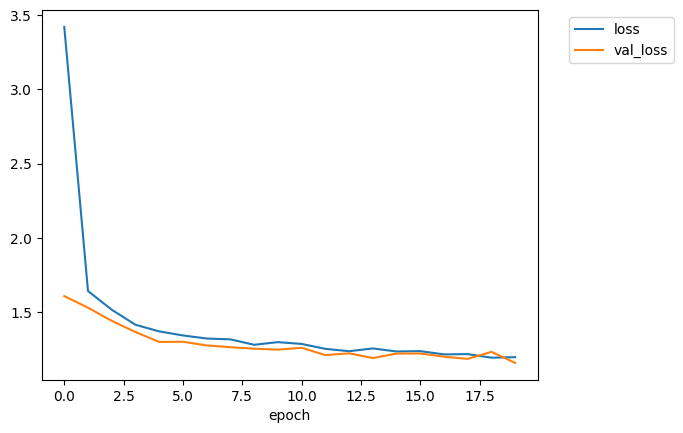

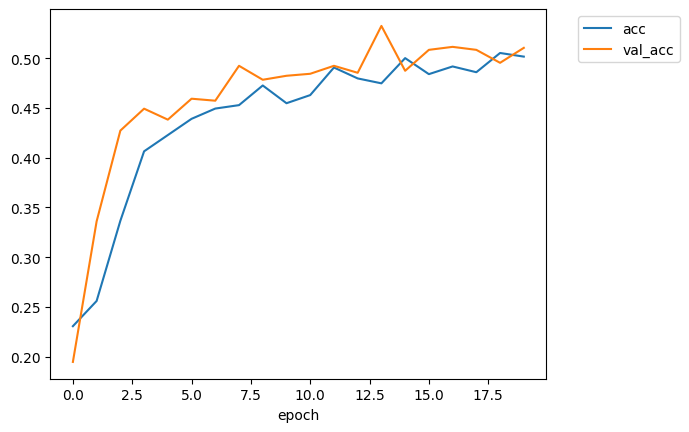

In [ ]:
display_training_curves(training_history)
#the dropout regularization allows the model to generalize more efficiently and we've put 64 neurons in the 2nd layer in order to avoid a too "brutal" compression

---


# CONVOLUTIONAL NEURAL NETWORK (CNN)


---

MLPs are great but CNNs should work better for our image classification problem...

For that, we will use new layers from TF.KERAS:
   - [tf.keras.layers.Conv2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) an example is:
```
l = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(l_input)
```
Here, we ask for 32 convolutional kernels of size [3,3]. By default the stride is set to '1' and the padding is 'valid'.

   - [tf.keras.layers.MaxPool2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) an example is:
```
l = tf.keras.layers.MaxPool2D()(l_input)
```
By default the stride is set to '2' and the padding is 'valid'.



We have O = (64-3+0)/1 + 1 = 62, and as we have 32 filters we expect to have the following tensor : [62,62,32]



If we reckon we begin with 64*64 pictures and add 32 layers, the output size is [32,32,32] (basically dividing 64 by 2)



---

Let's try to build a first CNN model with this architecture, on only **10 EPOCHS** (batch size = 150):

```
x --> Data Augmentation --> Conv2D (16 filters) ==> MaxPooling ==> Conv2D (8 filters) ==> MaxPooling ==> Flatten ==> Dense (nb_labels) --> ̂y
```



In [ ]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
import tensorflow as tf

inputs = tf.keras.Input(shape=(64,64,3))             #my input layer
x=tf.keras.layers.RandomFlip("horizontal")(inputs)   #two "data augmentation" layers
x=tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(16,kernel_size=3,activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(8,kernel_size=3,activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # my output layer

#Then, I define my model with the input layer, the output layer and a name
my_cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_cnn_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_cnn_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
#(a) Set the number of epochs
nb_epochs=10

#(b) Set the size of the (mini)batch
batch_size=150

#(c) Set the training dataset and the validation dataset (X_train, Y_train) and (X_val, Y_val)
#(d) Run the training process with the 'fit' method
training_history = my_cnn_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

# (4) COMPUTE THE ACCURACY ON THE TRAINING AND VALIDATION/TEST SETS
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)


Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_6 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 5)              │         7,845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,453 (36.93 KB)

 Trainable params: 9,453 (36.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2644 - loss: 1.6055 - val_accuracy: 0.4012 - val_loss: 1.4576
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4328 - loss: 1.3933 - val_accuracy: 0.4534 - val_loss: 1.3202
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4896 - loss: 1.2834 - val_accuracy: 0.4985 - val_loss: 1.2478
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5425 - loss: 1.2113 - val_accuracy: 0.5296 - val_loss: 1.2023
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5595 - loss: 1.1493 - val_accuracy: 0.5537 - val_loss: 1.1698
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5728 - loss: 1.1265 - val_accuracy: 0.5587 - val_loss: 1.1253
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5934 - loss: 1.0776 - val_accuracy: 0.5627 - val_loss: 1.1137
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5890 - loss: 1.0639 - val_accuracy: 0.5817 - v

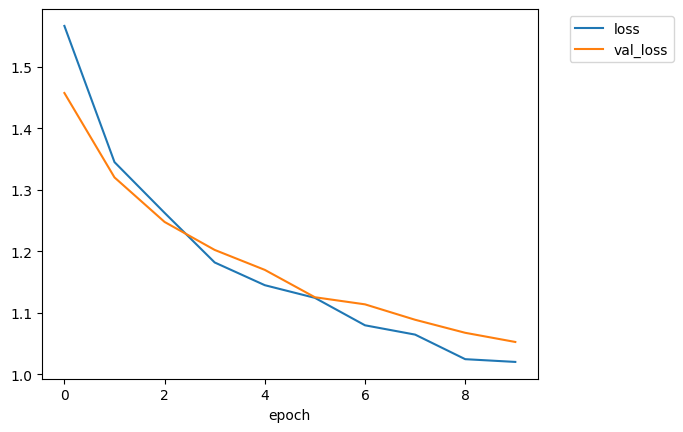

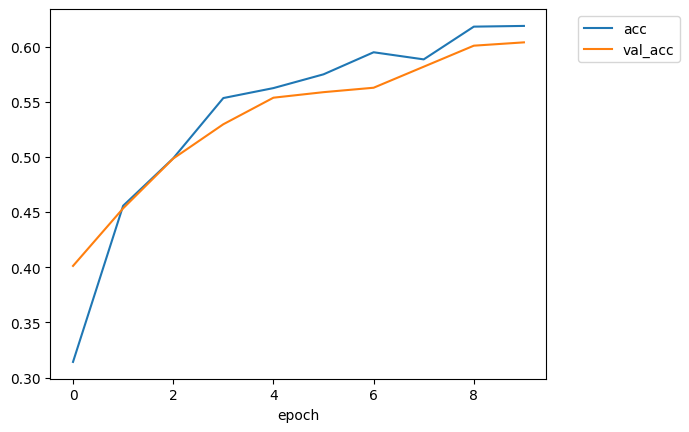

In [ ]:
#Your code here
display_training_curves(training_history)


---

## Improvements and overfitting

Like in the first part, we remove data augmentation to see the overfitting issue on the training curve!



In [ ]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
import tensorflow as tf

inputs = tf.keras.Input(shape=(64,64,3))             #my input layer
#x=tf.keras.layers.RandomFlip("horizontal")(inputs)   #we remove data augmentation to foster overfitting
#x=tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(16,kernel_size=3,activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(8,kernel_size=3,activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # my output layer

#Then, I define my model with the input layer, the output layer and a name
my_cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_cnn_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_cnn_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
#(a) Set the number of epochs
nb_epochs=15

#(b) Set the size of the (mini)batch
batch_size=150

#(c) Set the training dataset and the validation dataset (X_train, Y_train) and (X_val, Y_val)
#(d) Run the training process with the 'fit' method
training_history = my_cnn_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

# (4) COMPUTE THE ACCURACY ON THE TRAINING AND VALIDATION/TEST SETS
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)



Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 29, 29, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 5)              │         7,845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,453 (36.93 KB)

 Trainable params: 9,453 (36.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.2357 - loss: 1.5899 - val_accuracy: 0.3952 - val_loss: 1.4438
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4836 - loss: 1.3564 - val_accuracy: 0.5356 - val_loss: 1.1761
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5734 - loss: 1.1327 - val_accuracy: 0.5838 - val_loss: 1.0841
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6489 - loss: 0.9973 - val_accuracy: 0.6179 - val_loss: 1.0107
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6644 - loss: 0.9164 - val_accuracy: 0.6078 - val_loss: 0.9928
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6857 - loss: 0.8501 - val_accuracy: 0.6570 - val_loss: 0.9251
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7149 - loss: 0.8060 - val_accuracy: 0.6630 - val_loss: 0.8969
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7210 - loss: 0.7768 - val_accuracy: 0.6560 - v

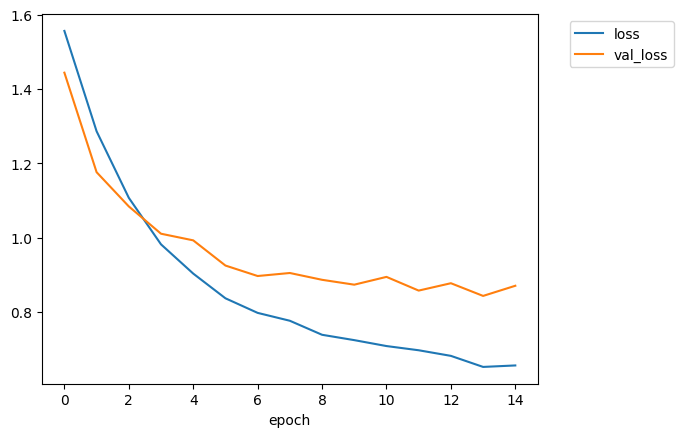

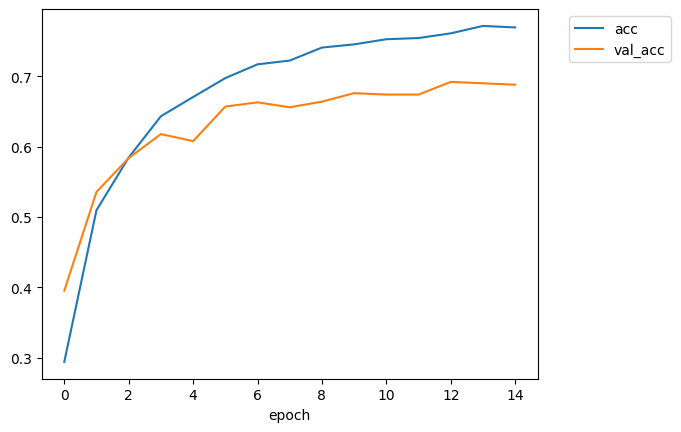

In [ ]:
display_training_curves(training_history)
#overfitting noticeable at the increasing gap btween the training loss curve and the validation one

---
Let's Fix my overfitting issue from the previous model by adapting my architecture with some constraints :
- **NB_EPOCHS=30**
- Less than 200k parameters
- Final performance around 80% for both training and test.


In [71]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
import tensorflow as tf

inputs = tf.keras.Input(shape=(64, 64, 3))  # my input layer

# x = tf.keras.layers.RandomFlip("horizontal")(inputs)  # two "data augmentation" layers
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128,kernel_size=3,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(3.3e-3))(inputs)
x = tf.keras.layers.SpatialDropout2D(0.3)(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(34,kernel_size=3,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(3.3e-3))(x)
x = tf.keras.layers.SpatialDropout2D(0.3)(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(5,activation='softmax')(x)  # my output layer

#Then, I define my model with the input layer, the output layer and a name
my_cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_cnn_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_cnn_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
#(a) Set the number of epochs
nb_epochs=30

#(b) Set the size of the (mini)batch
batch_size=32

#(c) Set the training dataset and the validation dataset (X_train, Y_train) and (X_val, Y_val)
#(d) Run the training process with the 'fit' method
training_history = my_cnn_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

# (4) COMPUTE THE ACCURACY ON THE TRAINING AND VALIDATION/TEST SETS
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)



Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 62, 62, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_76            │ (None, 62, 62, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 29, 29, 34)     │        39,202 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_77            │ (None, 29, 29, 34)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 14, 14, 34)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_39 (Flatten)            │ (None, 6664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 6664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 5)              │        33,325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,111 (297.31 KB)

 Trainable params: 76,111 (297.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.2784 - loss: 1.7108 - val_accuracy: 0.4654 - val_loss: 1.3479
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4938 - loss: 1.3470 - val_accuracy: 0.5958 - val_loss: 1.1544
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5689 - loss: 1.1756 - val_accuracy: 0.6008 - val_loss: 1.0922
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6030 - loss: 1.0854 - val_accuracy: 0.6489 - val_loss: 1.0107
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6264 - loss: 1.0601 - val_accuracy: 0.6590 - val_loss: 0.9701
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6631 - loss: 0.9838 - val_accuracy: 0.6720 - val_loss: 0.9489
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6596 - loss: 0.9860 - val_accuracy: 0.6720 - val_loss: 0.9410
Epoch 8/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6938 - loss: 0.9173 - val_acc

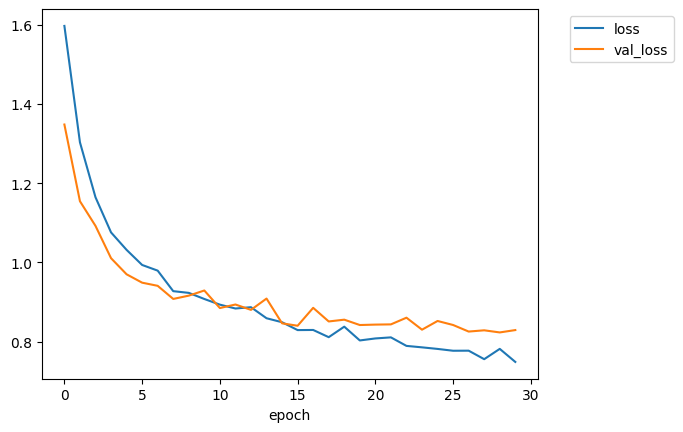

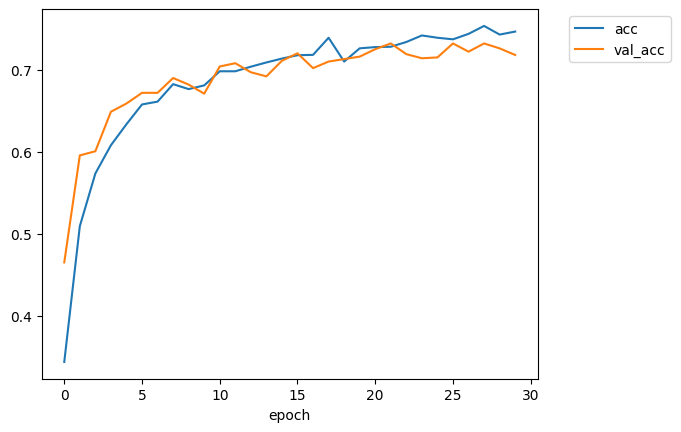

In [72]:
#Your code here
display_training_curves(training_history)
#we managed to signifcantly reduce overfitting even if there is a slowly increasing gap to be honest.

It seems that CNN are way better for image classification since its accuracy hits higher values
